# Load Data and Word-Embedding Models

In [1]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('train_data.json', 'r'))
val_data = json.load(open('val_data.json', 'r'))
test_data = json.load(open('test_data.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
random_vector = {}
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('random')
        if size not in random_vector:
            random_vector[size] = torch.randn(size)
        return random_vector[size]

# Vanilla RNN Implementation

In [3]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.rnn = nn.RNN(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device=x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:

def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {"B": 0, "I": 1, "O": 2}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"].split()
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [5]:
def test(model, embedding_model, test_data, device='cuda'):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B": 0, "I": 1, "O": 2}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    return accuracy, f1

In [6]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [7]:
input_size = 300  # Embedding size
hidden_size = 64  # Hidden size of the RNN
output_size = 3   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [8]:
rnn_word2vec_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_word2vec_model.parameters(), lr=0.001)

In [9]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2698, Accuracy: 0.9143, F1: 0.6403
Validation: Loss: 0.1784, Accuracy: 0.9377, F1: 0.7419
Epoch 2/10
Training: Loss: 0.1876, Accuracy: 0.9349, F1: 0.7653
Validation: Loss: 0.1682, Accuracy: 0.9406, F1: 0.7536
Epoch 3/10
Training: Loss: 0.1685, Accuracy: 0.9398, F1: 0.7854
Validation: Loss: 0.1667, Accuracy: 0.9416, F1: 0.7573
Epoch 4/10
Training: Loss: 0.1538, Accuracy: 0.9446, F1: 0.8047
Validation: Loss: 0.1658, Accuracy: 0.9413, F1: 0.7597
Epoch 5/10
Training: Loss: 0.1411, Accuracy: 0.9486, F1: 0.8234
Validation: Loss: 0.1684, Accuracy: 0.9413, F1: 0.7617
Epoch 6/10
Training: Loss: 0.1296, Accuracy: 0.9522, F1: 0.8372
Validation: Loss: 0.1729, Accuracy: 0.9418, F1: 0.7685
Epoch 7/10
Training: Loss: 0.1191, Accuracy: 0.9564, F1: 0.8523
Validation: Loss: 0.1754, Accuracy: 0.9423, F1: 0.7694
Epoch 8/10
Training: Loss: 0.1097, Accuracy: 0.9597, F1: 0.8648
Validation: Loss: 0.1784, Accuracy: 0.9447, F1: 0.7851
Epoch 9/10
Training: Loss: 0.1010, Accuracy: 0.9

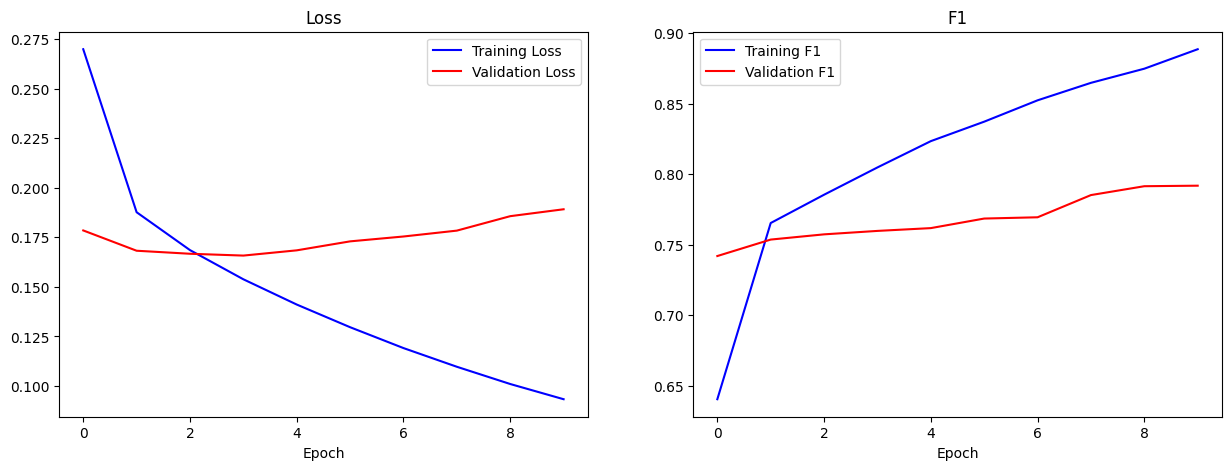

In [10]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [11]:
torch.save(rnn_word2vec_model, "t2_model1_word2vec.pt")

In [12]:
test_accuracy, test_f1 = test("t2_model1_word2vec.pt", word2vec, test_data, device='cuda')
print(("Vaniila RNN with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Vaniila RNN with Word2Vec ==> Accuracy: 0.9250, F1: 0.7591


# For GloVe Embeddings

In [13]:
rnn_glove_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_glove_model.parameters(), lr=0.001)

In [14]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2974, Accuracy: 0.9092, F1: 0.6033
Validation: Loss: 0.2189, Accuracy: 0.9257, F1: 0.6532
Epoch 2/10
Training: Loss: 0.2288, Accuracy: 0.9279, F1: 0.7124
Validation: Loss: 0.2041, Accuracy: 0.9320, F1: 0.6933
Epoch 3/10
Training: Loss: 0.2022, Accuracy: 0.9352, F1: 0.7467
Validation: Loss: 0.1986, Accuracy: 0.9356, F1: 0.7101
Epoch 4/10
Training: Loss: 0.1803, Accuracy: 0.9405, F1: 0.7724
Validation: Loss: 0.1966, Accuracy: 0.9353, F1: 0.7064
Epoch 5/10
Training: Loss: 0.1614, Accuracy: 0.9469, F1: 0.7990
Validation: Loss: 0.1965, Accuracy: 0.9365, F1: 0.7169
Epoch 6/10
Training: Loss: 0.1441, Accuracy: 0.9526, F1: 0.8244
Validation: Loss: 0.1987, Accuracy: 0.9363, F1: 0.7222
Epoch 7/10
Training: Loss: 0.1298, Accuracy: 0.9585, F1: 0.8492
Validation: Loss: 0.2037, Accuracy: 0.9360, F1: 0.7227
Epoch 8/10
Training: Loss: 0.1178, Accuracy: 0.9621, F1: 0.8631
Validation: Loss: 0.2095, Accuracy: 0.9353, F1: 0.7225
Epoch 9/10
Training: Loss: 0.1056, Accuracy: 0.9

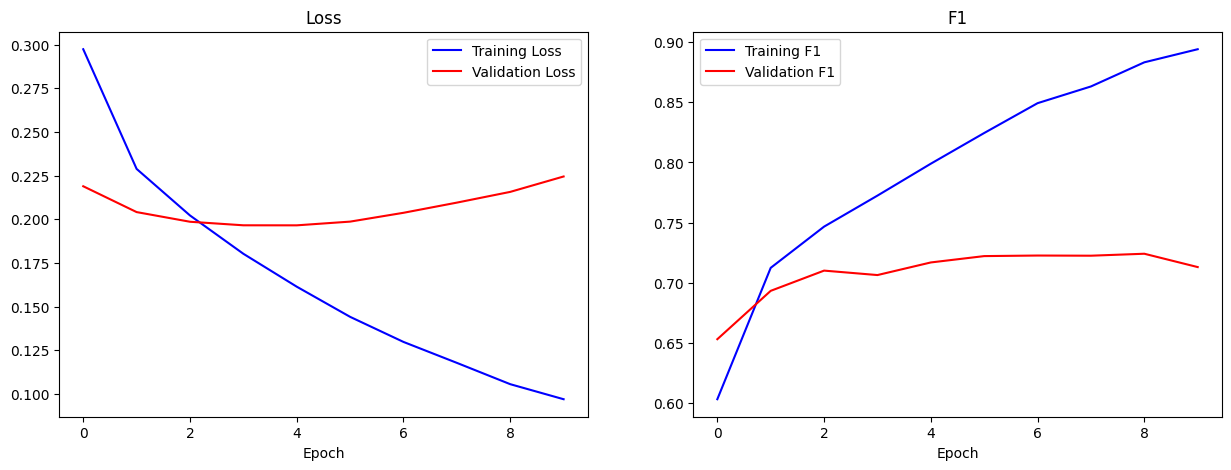

In [15]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [16]:
torch.save(rnn_glove_model, "t2_model1_glove.pt")

In [17]:
test_accuracy, test_f1 = test("t2_model1_glove.pt", glove, test_data, device='cuda')
print(("Vaniila RNN with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Vaniila RNN with GloVe ==> Accuracy: 0.9023, F1: 0.6601


# For FastText Embeddings

In [18]:
rnn_fasttext_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_fasttext_model.parameters(), lr=0.001)

In [19]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        rnn_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10


Training: Loss: 0.2771, Accuracy: 0.9126, F1: 0.6078
Validation: Loss: 0.1814, Accuracy: 0.9341, F1: 0.7014
Epoch 2/10
Training: Loss: 0.1865, Accuracy: 0.9325, F1: 0.7473
Validation: Loss: 0.1672, Accuracy: 0.9418, F1: 0.7393
Epoch 3/10
Training: Loss: 0.1681, Accuracy: 0.9392, F1: 0.7785
Validation: Loss: 0.1619, Accuracy: 0.9428, F1: 0.7406
Epoch 4/10
Training: Loss: 0.1553, Accuracy: 0.9419, F1: 0.7900
Validation: Loss: 0.1610, Accuracy: 0.9420, F1: 0.7396
Epoch 5/10
Training: Loss: 0.1452, Accuracy: 0.9460, F1: 0.8069
Validation: Loss: 0.1624, Accuracy: 0.9418, F1: 0.7439
Epoch 6/10
Training: Loss: 0.1363, Accuracy: 0.9493, F1: 0.8189
Validation: Loss: 0.1651, Accuracy: 0.9432, F1: 0.7552
Epoch 7/10
Training: Loss: 0.1278, Accuracy: 0.9523, F1: 0.8325
Validation: Loss: 0.1683, Accuracy: 0.9411, F1: 0.7561
Epoch 8/10
Training: Loss: 0.1199, Accuracy: 0.9545, F1: 0.8414
Validation: Loss: 0.1729, Accuracy: 0.9392, F1: 0.7514
Epoch 9/10
Training: Loss: 0.1120, Accuracy: 0.9570, F1: 0.

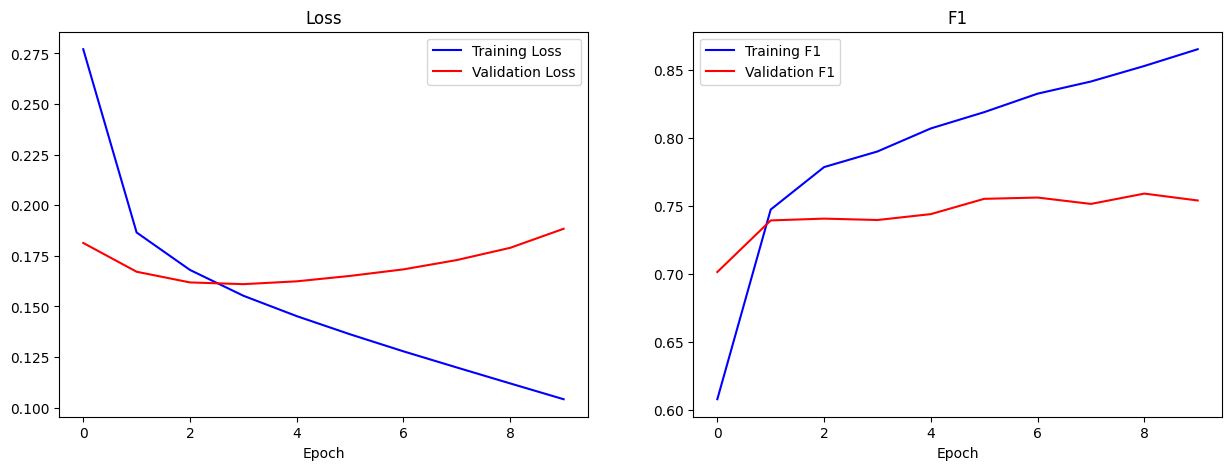

In [20]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [21]:
torch.save(rnn_fasttext_model, "t2_model1_fasttext.pt")

In [22]:
test_accuracy, test_f1 = test("t2_model1_fasttext.pt", fasttext, test_data, device='cuda')
print(("Vaniila RNN with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Vaniila RNN with FastText ==> Accuracy: 0.9201, F1: 0.7375
